In [1]:
# Ref. https://github.com/roatienza/Deep-Learning-Experiments/blob/master/Experiments/Tensorflow/GAN/dcgan_mnist.py

#### loading interdependecies

In [2]:
import numpy as np
import time
from tensorflow.examples.tutorials.mnist import input_data 

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop

Using TensorFlow backend.


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

#### defining timer

In [4]:
class ElapsedTimer():
    
    def __init__(self):
        self.start_time = time.time()
        
    def elapsed(self, sec):
        if sec < 60:
            return str(sec) + "sec"
        elif sec < (60 * 60):
            return str(sec/60) + 'min'
        else:
            return str(sec / (60 * 60 )) + 'hr'
    def elapsed_time(self):
        print('Elapsed: %s ' % self.elapsed(time.time() - self.start_time))

#### defining GANs template

In [5]:
class DCGAN():
    
    def __init__(self, img_rows=28, img_cols=28, channel=1):
        
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        
        self.D = None 
        self.G = None
        
        self.AM = None
        self.DM = None
        
        # defining the discriminator : D
                        
    def discriminator(self):
        
        if self.D:
            return self.D
        
        self.D = Sequential()     #we assign a sequential model to D
        depth = 64
        dropout = 0.4
            
        input_shape = (self.img_rows, self.img_cols, self.channel)
            
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))
            
        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))
            
        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))
            
        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))
            
        self.D.add(Flatten())            
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        
        return self.D
        
        #defining the generator: G
        
    def generator(self):
        if self.G:
            return self.G
        
        self.G = Sequential() #we also assing a sequential model to G
        dropout = 0.4
        depth = 64+64+64+64
        dim = 7
            
        self.G.add(Dense(dim*dim*depth, input_dim=100))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim, dim, depth)))
        self.G.add(Dropout(dropout))
            
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
            
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
            
        self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
            
        self.G.add(Conv2DTranspose(1, 5, padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()
            
        return self.G
    
    # now, we have to define the models (discriminator and adversarial)
        
    def discriminator_model(self):
        if self.DM:
            return self.DM
            
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        self.DM = Sequential() # a sequence model 
        self.DM.add(self.discriminator()) # instancing discriminator 
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
            
        return self.DM
    
    def adversarial_model(self):
        if self.AM:
            return self.AM
        
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        self.AM = Sequential()  # a sequence model
        self.AM.add(self.generator()) #instancing the generator
        self.AM.add(self.discriminator()) #instancing the discriminator
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
            
        return self.AM  



#### instancing the GANs (mnist) 

In [6]:
class MNIST_DCGAN():
    
    # model for the GAN
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1
        
        self.x_train = input_data.read_data_sets('mnist', one_hot=True).train.images
        self.x_train = self.x_train.reshape(-1, self.img_rows, self.img_cols, self.channel).astype(np.float32)
        
             
        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()
        
    #training for the GAN
    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        
        noise_input = None
        
        if save_interval > 0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
            
        for i in range(train_steps):
            images_train = self.x_train[np.random.randint(0, self.x_train.shape[0], size=batch_size), :, :, :]
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = self.generator.predict(noise)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = self.discriminator.train_on_batch(x, y)
            
            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            log_mesg = '%d: [D loss: %f, acc: %f]' % (i, d_loss[0], d_loss[1])
            log_mesg = '%s  [A loss: %f, acc: %f]' % (log_mesg, a_loss[0], a_loss[1])
            
            print(log_mesg)
            
            if save_interval > 0:
                
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, samples=noise_input.shape[0], noise=noise_input, step=(i+1))
    
    #defining the plot of images
    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        filename = 'mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = 'mnist_%d.png' % step
            images = self.generator.predict(noise)
        
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]
            
        plt.figure(figsize=(12,12))           
        
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
            
        plt.tight_layout()
        
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()      

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0 

13: [D loss: 0.316039, acc: 0.984375]  [A loss: 1.730514, acc: 0.000000]
14: [D loss: 0.280502, acc: 1.000000]  [A loss: 1.812401, acc: 0.000000]
Elapsed: 13.952192282676696min 


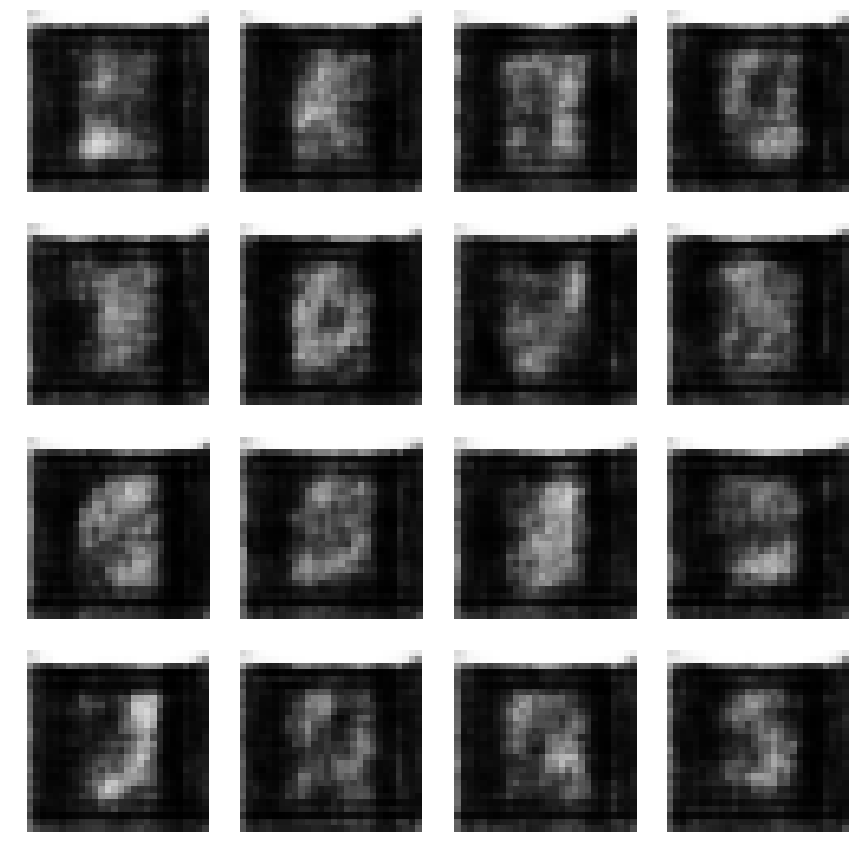

In [7]:
mnist_dcgan = MNIST_DCGAN()
timer = ElapsedTimer()
mnist_dcgan.train(train_steps=15, batch_size=256, save_interval=500)  #only 15 epochs
timer.elapsed_time()
mnist_dcgan.plot_images(fake=True)
mnist_dcgan.plot_images(fake=False, save2file=True)    